In [16]:
from ambient_api.ambientapi import AmbientAPI
import os, time
import pandas as pd
import numpy as np
import datetime as dt
import dateutil.parser
from matplotlib import pyplot as plt
import act
import xarray as xr
import json

%matplotlib inline

In [17]:
with open('/Users/scollis/data/testjson.json') as textfile:
    data = textfile.readlines()
   

In [18]:
jsonit = json.loads(data[-1])

In [19]:
jsonit

{'time': '2020-07-28 21:04:35',
 'model': 'Fineoffset-WH65B',
 'id': 19,
 'battery_ok': 1,
 'temperature_C': 30.9,
 'humidity': 46,
 'wind_dir_deg': 171,
 'wind_avg_m_s': 0.255,
 'wind_max_m_s': 0.51,
 'rain_mm': 205.232,
 'uv': 2473,
 'uvi': 6,
 'light_lux': 83421.0,
 'mic': 'CRC'}

In [20]:
print("Temperature : " + str(jsonit['temperature_C']))


Temperature : 30.9


In [21]:
jdatas = []
for this in data:
    try:
        tjs = json.loads(this)
        jdatas.append(tjs)
    except json.JSONDecodeError:
        print(this)
        

In [22]:
first_WH24 = True
first_WH65B = True
good_jdatas = []
for dat in jdatas:
    if 'WH65B' in dat['model']:
        if first_WH65B:
            start_rain_65 = float(dat['rain_mm'])
            dat['rain_mm'] = 0.
            first_WH65B = False
        else:
            dat['rain_mm'] = (float(dat['rain_mm']) - start_rain_65)
        good_jdatas.append(dat) 
    if 'WH24' in jdatas:
        if first_WH24:
            start_rain_24 = float(dat['rain_mm'])
            dat['rain_mm'] = 0
            first_WH24 = False
        else:
            dat['rain_mm'] = (float(dat['rain_mm']) - start_rain_24)
        good_jdatas.append(dat)
            
        

In [23]:
really_good = []
for i in range(len(good_jdatas)):
    if 'uvi' in good_jdatas[i].keys():
        #print(good_jdatas[i])
        really_good.append(good_jdatas[i])

In [24]:
#dt.datetime(2020,6,5,0,0)
def ingest_915_jsons(my_data):
    dates = np.array([pd.to_datetime(element['time']) for element in my_data])
    ordd = dates.argsort()
    dates = dates[ordd].astype('datetime64[ns]')
    
    mapn = {'temperature_C': 'outside_temperature',
            'humidity' : 'humidity',
            'rain_mm' : "total_rainfall",
            'light_lux' : "solar_lux",
            'wind_dir_deg' : 'wind_direction',
            'wind_avg_m_s' : 'wind_speed',
            'wind_max_m_s' : 'max_wind_speed',
            'uvi' : 'uv_index',
            'uv' : 'UV'}


    dont_care = [ 'time', 'loc', 'lastRain', 'tz', 'macAddress', 'battery_ok', 'model', 'id', 'mic', 'uv']
    numpy_data = {}
    for variable in list(my_data[0].keys()):
        if variable not in dont_care:
            #print(variable)
            vim = []
            for element in my_data:
                vim.append(element[variable])
            this = np.array(vim)
                
            #this = np.array([element[variable] for element in my_data])[ordd]
            numpy_data.update({mapn[variable] : (['time'], this)})
    
    tu = 'C'
    tsn = 'Temperature'
    dpsn = 'Dewpoint'
    xds = xr.Dataset(numpy_data,
                coords={'time' : dates })
    
    #xds['inside_temperature'].attrs = {'standard_name' : tsn, 'units' : tu, 'long_name' : 'inside_temperature'}
    xds['outside_temperature'].attrs = {'standard_name' : tsn, 'units' : tu, 'long_name' : 'outside_temperature'}
    #xds['outside_dewpoint'].attrs = {'standard_name' : dpsn, 'units' : tu, 'long_name' : 'outside dewpoint'}
    #xds['inside_dewpoint'].attrs = {'standard_name' : dpsn, 'units' : tu, 'long_name' : 'inside dewpoint'}
    xds['total_rainfall'].attrs = {'standard_name' : 'rainfall', 'units' : 'mm', 'long_name' : 'Total Rainfall'}
    xds.attrs['datastream'] = 'Beer And Bike Barn Met Station'
    
    return xds



In [25]:
mxr = ingest_915_jsons(really_good)

In [26]:
mxr.variables.keys()

KeysView(Frozen({'outside_temperature': <xarray.Variable (time: 30873)>
array([23.9, 23.9, 24.1, ..., 31.4, 31.1, 30.9])
Attributes:
    standard_name:  Temperature
    units:          C
    long_name:      outside_temperature, 'humidity': <xarray.Variable (time: 30873)>
array([65, 63, 62, ..., 45, 45, 46]), 'wind_direction': <xarray.Variable (time: 30873)>
array([ 77,  83,  34, ...,  50, 231, 171]), 'wind_speed': <xarray.Variable (time: 30873)>
array([0.   , 0.382, 0.765, ..., 0.892, 1.084, 0.255]), 'max_wind_speed': <xarray.Variable (time: 30873)>
array([0.  , 0.51, 1.02, ..., 1.02, 1.53, 0.51]), 'total_rainfall': <xarray.Variable (time: 30873)>
array([ 0.   ,  0.   ,  0.   , ..., 24.638, 24.638, 24.638])
Attributes:
    standard_name:  rainfall
    units:          mm
    long_name:      Total Rainfall, 'uv_index': <xarray.Variable (time: 30873)>
array([8, 8, 8, ..., 0, 6, 6]), 'solar_lux': <xarray.Variable (time: 30873)>
array([104640., 104857., 105524., ...,  22475.,  84800.,  8342

In [27]:
mxr['solar_irrad'] = mxr['solar_lux'] *  0.0079

In [28]:
td = 243.04*(np.log(mxr['humidity']/100.)\
             + ((17.625*mxr['outside_temperature'])/(243.04+mxr['outside_temperature'])))/(17.625-np.log(mxr['humidity']/100)\
            -((17.625*mxr['outside_temperature'])/(243.04+mxr['outside_temperature'])))

In [29]:
mxr['outside_dewpoint'] = td
tu = 'F'
tsn = 'Temperature'
dpsn = 'Dewpoint'
mxr['outside_dewpoint'].attrs = {'standard_name' : dpsn, 'units' : tu, 'long_name' : 'outside dewpoint'}


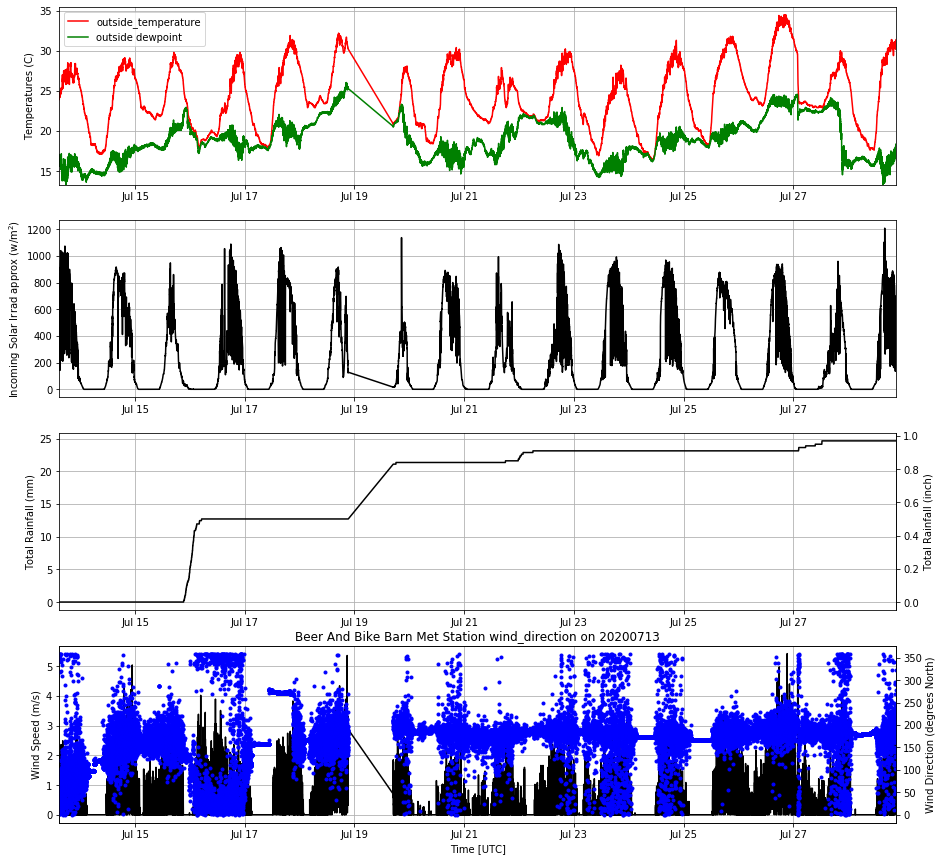

In [30]:

my_disp = act.plotting.TimeSeriesDisplay(
    (mxr), figsize=(15, 15), subplot_shape=(4, ))
my_disp.plot('outside_temperature', marker=None, linestyle='-', color='red', 
             label = mxr['outside_temperature'].attrs['long_name'], subplot_index=(0, ))
#my_disp.plot('inside_temperature',  marker=None, linestyle='--', color='red', 
#             label = mxr['inside_temperature'].attrs['long_name'], subplot_index=(0, ))
#my_disp.plot('inside_dewpoint',  marker=None, linestyle='--', color='green', 
#             label = mxr['inside_dewpoint'].attrs['long_name'], subplot_index=(0, ))
my_disp.plot('outside_dewpoint', marker=None, linestyle='-', color='green', 
             label = mxr['outside_dewpoint'].attrs['long_name'], subplot_index=(0, ))

my_disp.day_night_background('Beer And Bike Barn Met Station')

my_disp.axes[0].grid()
my_disp.axes[0].legend()
my_disp.axes[1].grid()


my_disp.plot('solar_irrad',  marker='None', linestyle='-', color='black', 
            subplot_index=(1, ))

my_disp.plot('total_rainfall',  marker='None', linestyle='-', color='black', label = 'Rainfall', 
            subplot_index=(2, ))


my_disp.plot('wind_speed',  marker='None', linestyle='-', color='black', 
            subplot_index=(3, ))

my_disp.axes[2].grid()

my_disp.axes[3].grid()

my_disp.axes = np.append(my_disp.axes, plt.twinx())
my_disp.xrng = np.append(my_disp.xrng, np.expand_dims(my_disp.xrng[-1,:], axis=0) , axis=0)
my_disp.yrng = np.append(my_disp.yrng, np.expand_dims(my_disp.yrng[-1,:], axis=0) , axis=0)
my_disp.yrng[-1, 0] = 0
my_disp.yrng[-1, 1] = 360

my_disp.plot('wind_direction',  marker='.', color='blue', 
            subplot_index=(4, ))


my_disp.axes[0].set_title('')
my_disp.axes[1].set_title('')
my_disp.axes[2].set_title('')
my_disp.axes[3].set_title('')

def mm2inch(mm):
    return mm*0.0393701

def inch2mm(inc):
    return inc/0.0393701

my_disp.axes[0].set_ylabel('Temperatures (C)')
my_disp.axes[1].set_ylabel(r'Incoming Solar Irrad approx (w/m$^2$)')
my_disp.axes[2].set_ylabel('Total Rainfall (mm)')
secaxy = my_disp.axes[2].secondary_yaxis('right', functions=( mm2inch,inch2mm,))
secaxy.set_ylabel('Total Rainfall (inch)')
my_disp.axes[3].set_ylabel('Wind Speed (m/s)')
my_disp.axes[4].set_ylabel('Wind Direction (degrees North)')
plt.savefig('/Users/scollis/foo.png')
